# Design Single Country Nat Cat Bonds

In [1]:
#import general packages
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

#import climada stuff
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.util.api_client import Client
from climada.engine import ImpactCalc

%load_ext autoreload
%autoreload 2
import haz_storm as hst
import exposures as ex
import grider as grd
import impact as cimp
import bound_prot_dam as bpd
import prem_ibrd as prib
import haz_int_grd as hig
import set_nominal as snom
import functions as fct
import calc_premium as cp
import simulate_bond as sb
import alt_pay_opt as apo
client = Client()

c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


## Perform natural hazard simulation 
### Define variables for cat bonds

In [2]:
#choose storm basin to load
#The STORM basins are: 'EP','NA','NI','SI','SP','WP'
basins = ['SI']

#choose country
country = 174

#number of simulated years
r = 10000

#define maximum and minimum return periods to be covered
upper_rp = 200
lower_rp = 100

### Load TC Tracks for basin

currently not needed because I incorporated it into the ex.init_TC_exp function -> still coudnt figure out how to load exisitng tc track files -> it takes forever without throwing an error

In [3]:
#storms_basin = hst.init_STORM_tracks(basins=basins, load_fls=False)

### Generate Exposure Data and TC hazards impacting selected exposure
1. Generate exposure data using newest available data. Can choose fin_mode myself, reference year, and resolution. <br>
2. Generate centroids at the locations of the exposed assets <br>
3. Filter tc tracks so that dataset only includes tracks which affect chosen exposure locations <br>
4. Generate tc hazards


STORM basin of country:  SI
----------------------Initiating Exposure----------------------


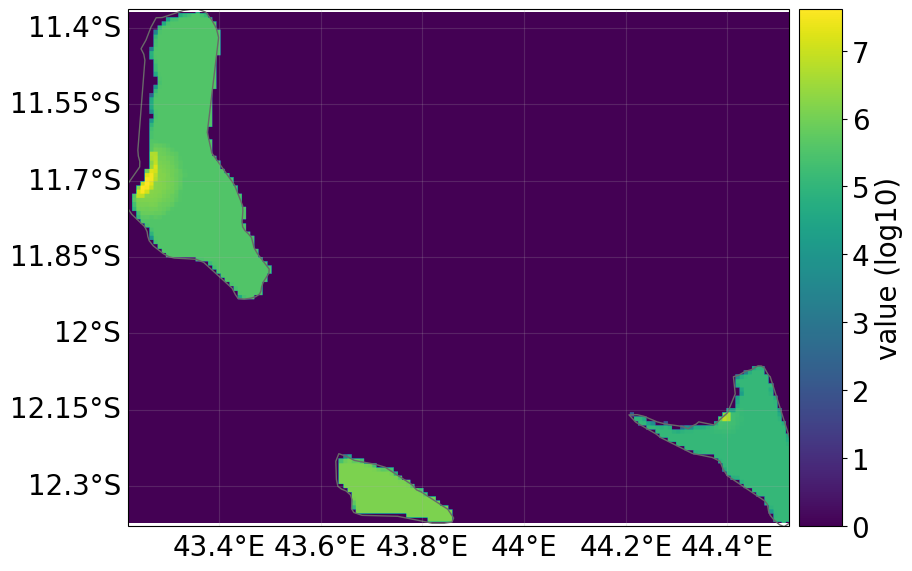

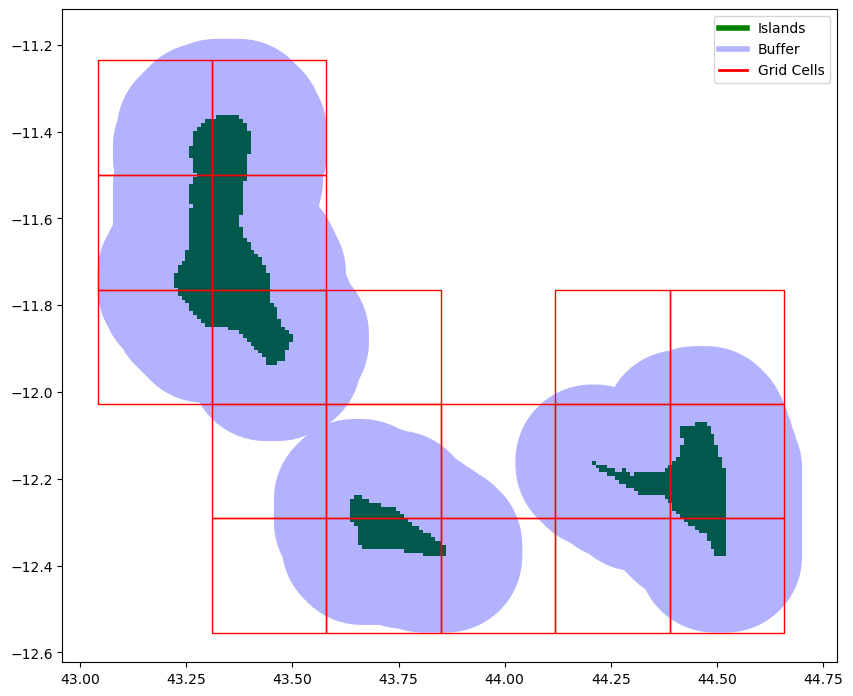

----------------------Generate Hazard----------------------
----------------------Initiating TC Tracks----------------------


c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\geopandas\geodataframe.py:204: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  object.__setattr__(self, attr, val)
c:\users\kaibe\climada\climada_python\climada\hazard\tc_tracks.py:1511: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_one_interp_data" failed type inference due to: non-precise type pyobject
During: typing of argument at c:\users\kaibe\climada\climada_python\climada\hazard\tc_tracks.py (1545)

File "..\..\..\..\climada\climada_python\climada\hazard\tc_tracks.py", line 1545:
    de

Number of tracks in SI basin: 229


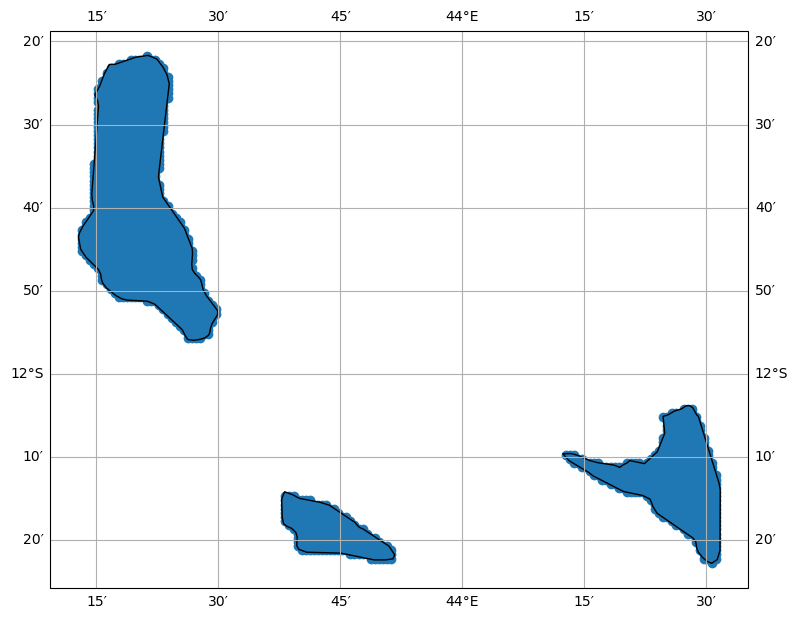

In [3]:
exp, applicable_basins, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = ex.init_TC_exp(country, load_fls=False)

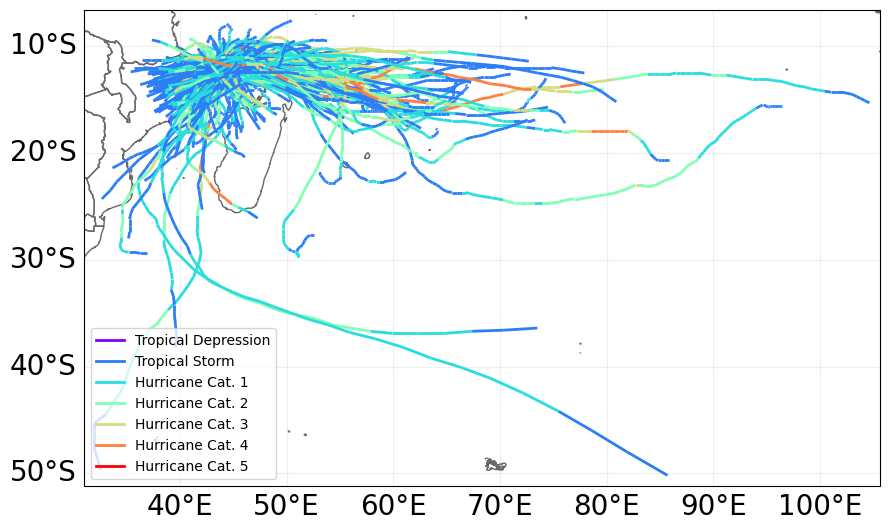

In [49]:
#plot filtered tc hazards
ax_sub = storm_basin_sub.plot()
ax_sub.get_legend()._loc = 3

### Calculate Impact
1. Calculate impact matrix
2. Determine exposure points per grid cell
3. Calculate total impacts per grid cell and event

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\impact.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


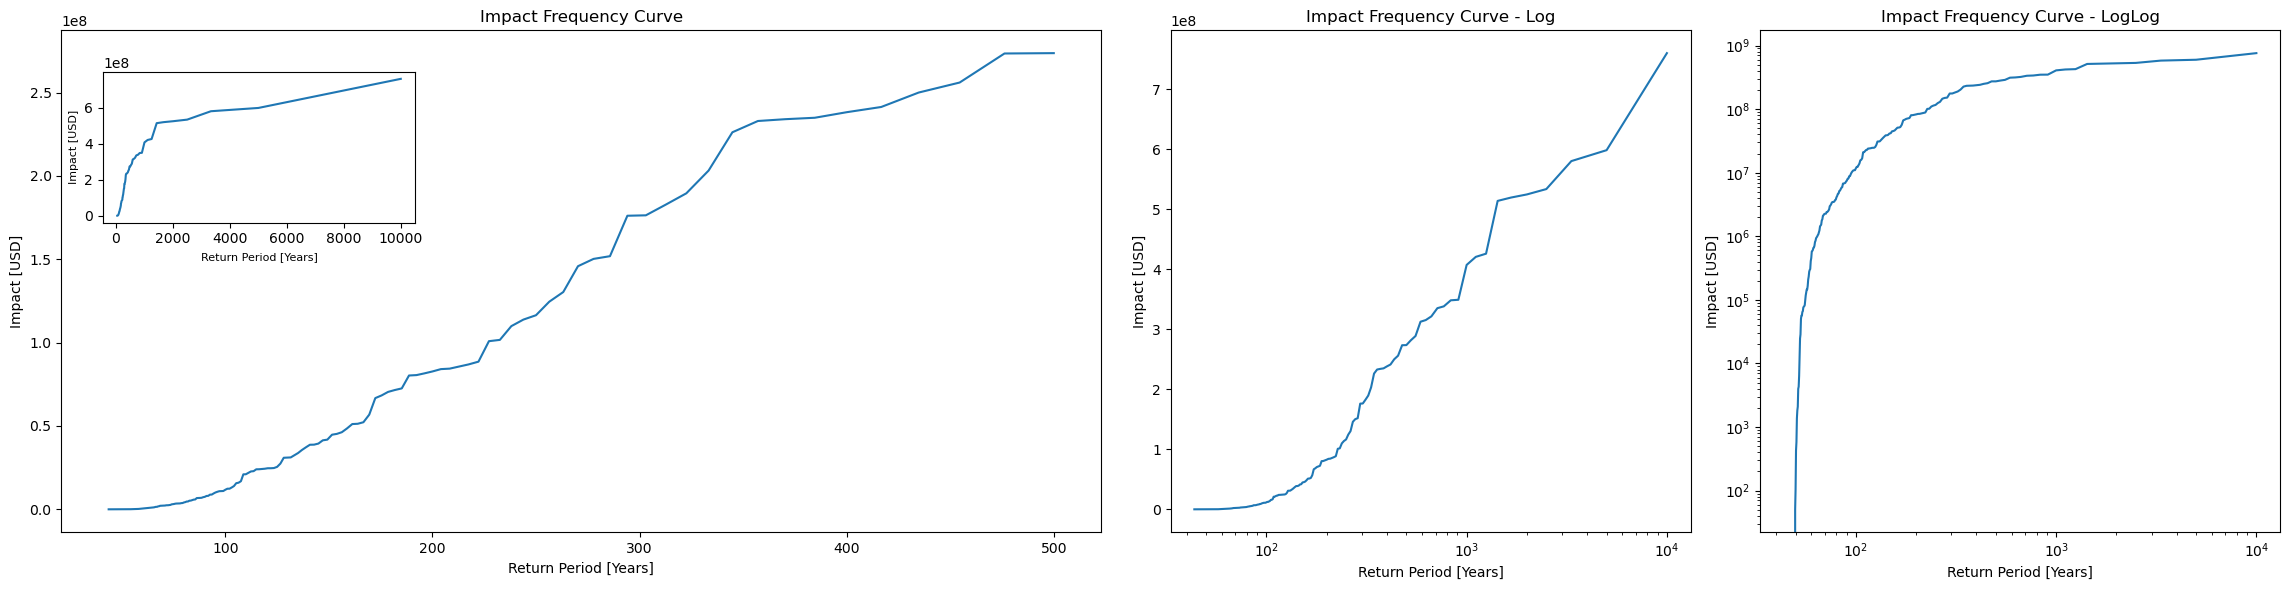

In [112]:
imp, imp_per_event, imp_admin_evt = cimp.init_imp(exp, tc_storms, admin_gdf) 
imp_per_event_flt = bpd.init_imp_flt(imp_per_event, lower_rp)

## Optimize insurance policies

### Asses hazard intensity per event and grid cell
1. Creation of data frame which indicates the sustained wind speed per event and grid cell caclualted using a quantile or the mean across hazard centroid located in each grid cell.
2. Add year for each event.

In [163]:
int_grid = hig.init_haz_int(grid_gdf, admin_gdf, tc_tracks=storm_basin_sub) #tc_tracks=storm_basin_sub.........tc_storms=tc_storms

#### Set the nominal
Can be set in diferent ways:
1. Protecting a specified percentage of e.g. GDP
2. Protecting damages of specified return period

In [164]:
#define nominal
nominal, tot_exp, nom_rel_exp = snom.init_nominal(impact=imp, exposure=exp, prot_rp=upper_rp)

The principal of the cat bond is: 82706984.79131922
Principal as percentage of GDP: 0.06751374569901876


### Set boundarys for protected damage
1. Calculate damage return periods for grid cells
2. Set minimum damage which should be protected per grid cell
3. Adjust damage per grid and event dictionary. Damage below minimum damage should be zero. Optionally we can also set the maximum damage to the nominal, but the default is not to.

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\bound_prot_dam.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


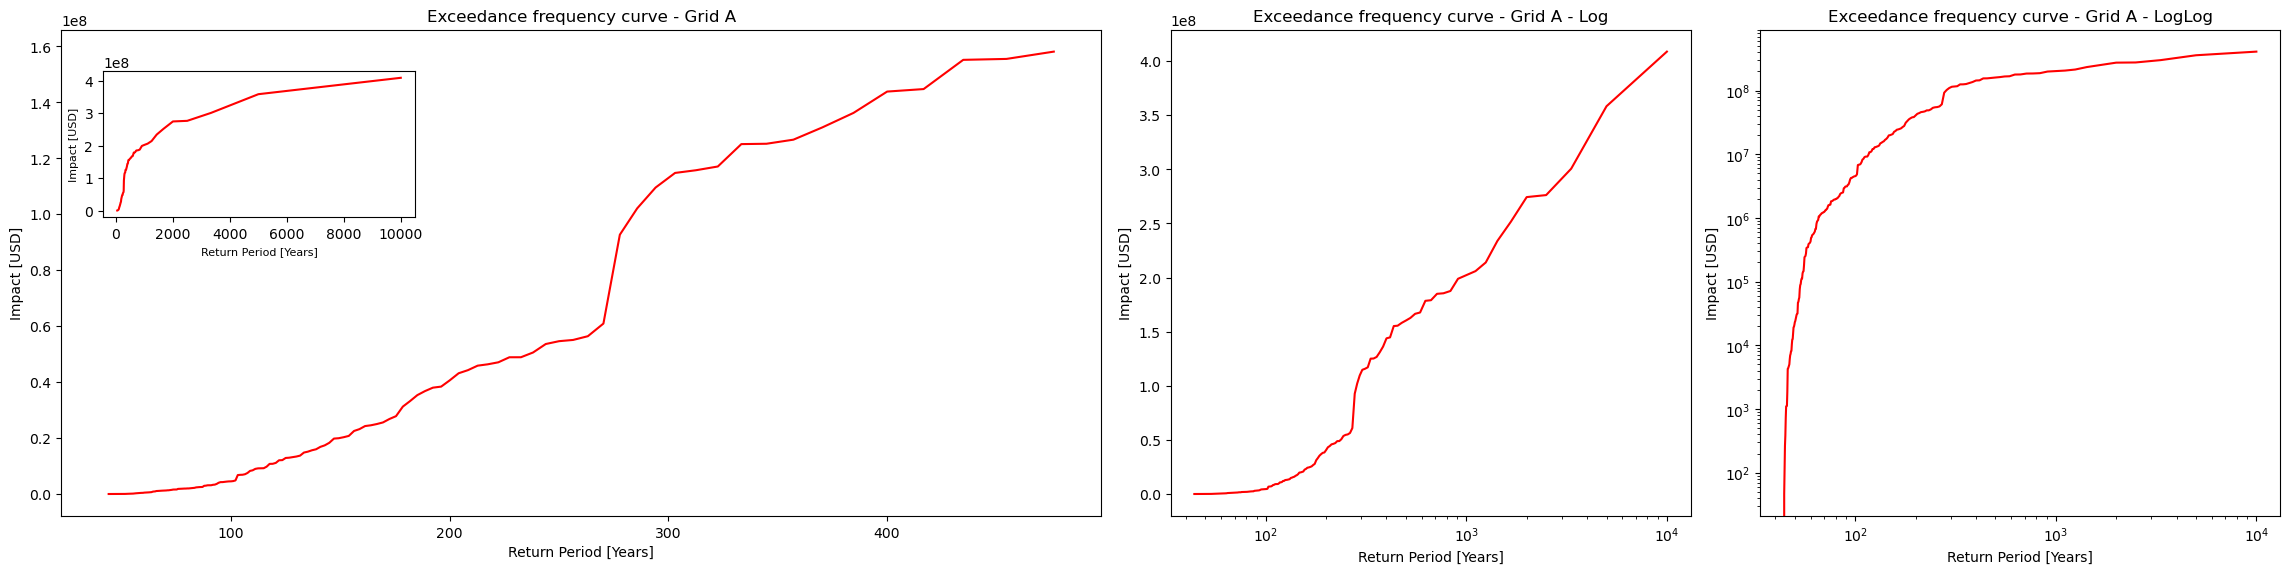

In [58]:
#rp_dam_grid, dam_rp_per_grid, imp_grid_evt_flt = bpd.init_dam_ret_per_grid(imp_grid_evt, lower_rp, adj_max=False, plt_dam_rp_grid='A')

### Perform optimization
Optmizie payout function using linear payout inbetween a minimung triggering and a maximum wind speed. Wind speeds equal or higher than maximum wind speed result in the payout of the full principle. <br>
Wind speeds are optimized for each grid cell.

In [178]:
result, optimized_step1, optimized_step2, optimized_step3 = apo.init_alt_optimization(int_grid, nominal, damages_grid=imp_admin_evt, damages_evt=imp_per_event_flt)

{0: (983.0, 940.0, 915.0), 1: (981.0, 940.0, 915.0), 2: (982.0, 940.0, 915.0), 3: (980.0, 940.0, 915.0), 4: (980.0, 940.0, 915.0), 5: (986.4834712063445, 938.2135319215964, 915.5645021828717), 6: (983.0, 940.0, 915.0), 7: (984.8164965809277, 939.5917517095361, 914.5917517095361), 8: (980.0, 940.0, 915.0), 9: (981.0, 940.0, 915.0), 10: (983.0, 940.0, 915.0), 11: (982.0, 940.0, 915.0), 12: (983.8164965809277, 940.4082482904639, 915.4082482904639), 13: (982.0, 940.0, 915.0), 14: (983.5773502691897, 939.4226497308103, 914.4226497308103), 15: (984.4061336085116, 939.6563106470201, 915.7030668042557), 16: (981.0, 940.0, 915.0), 17: (983.0, 940.0, 915.0), 18: (984.6329931618554, 940.8164965809278, 915.8164965809278)}


### Assess payout vs damage for each event
1. Create a payout vs damage matrix per event
2. Plot payout vs damage on 1:1 scale

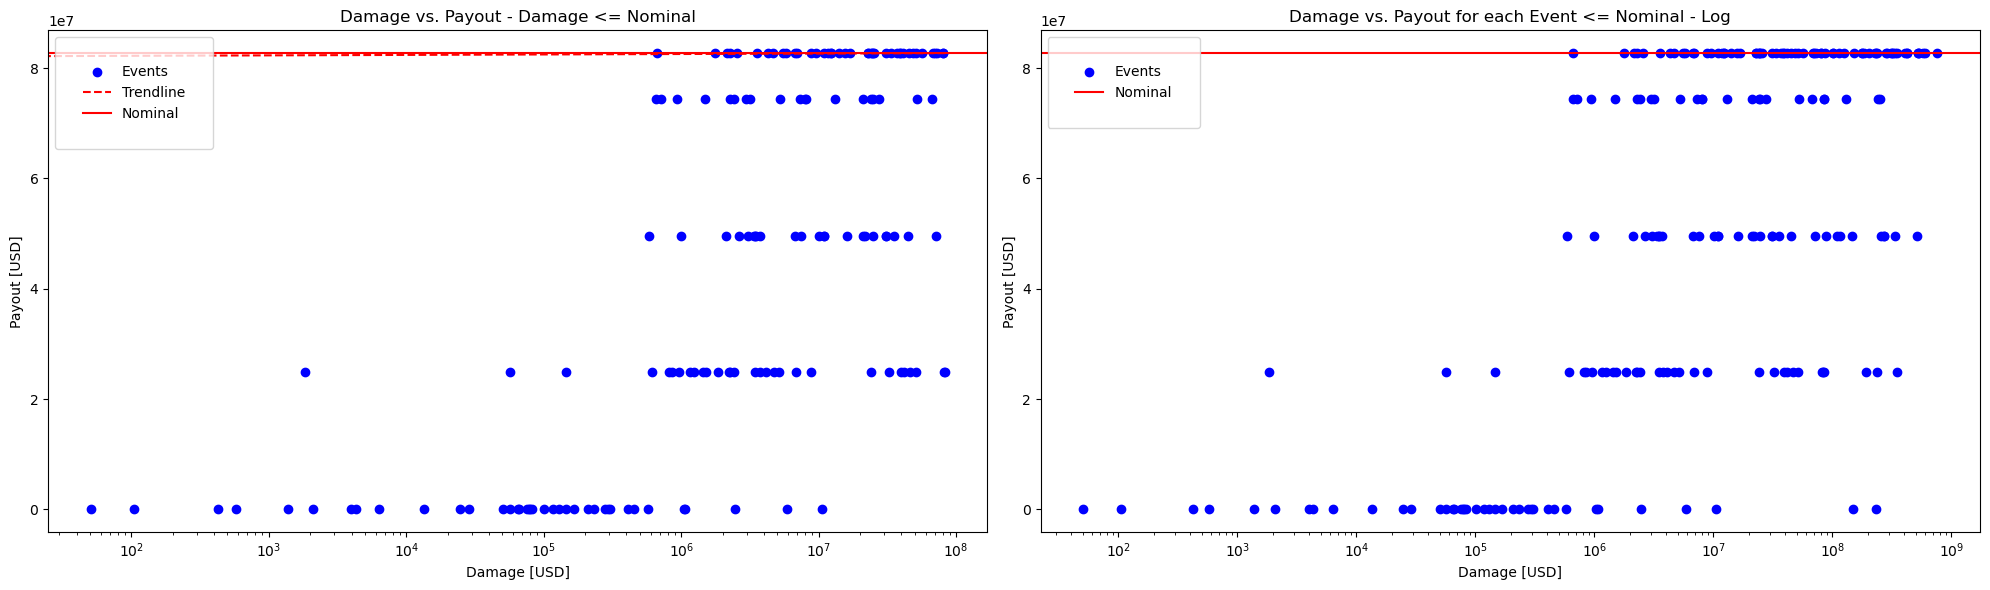

In [179]:
pay_dam_df = apo.alt_pay_vs_damage(imp_per_event, optimized_step1, optimized_step2, optimized_step3, int_grid, nominal, include_plot=True)

### Calculate expected loss and attachment probability
1. Set annual probaility for hazard event
2. Simulate cat bond and calculate the expected loss as well as the annual attachment probability.

In [185]:
exp_loss_ann, att_prob, ann_losses, es_metrics = sb.init_exp_loss_att_prob_simulation(pay_dam_df, nominal)

Expected Loss = 0.0120290724811629
Attachment Probability = 0.016003200640128022


### Calculate premiums using:
1. IBRD multiplier model
2. Most recent artemis multiplier
3. Linear regression model of Chatoro et al. 2022

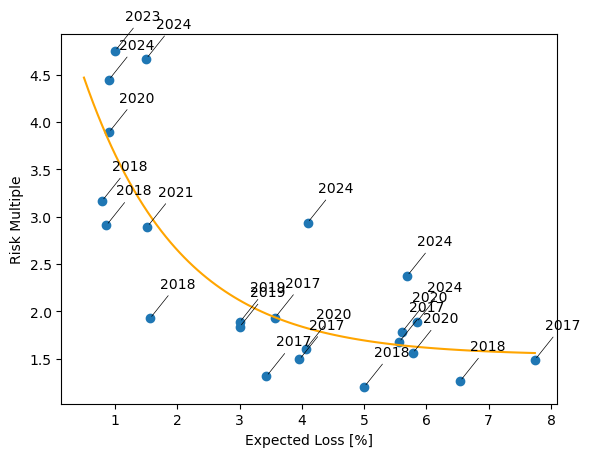

The premium based on past IBRD bonds is 4.085%
The premium based on the artemis multiplier is 4.944%
The premium based on the regression model from Chatoro et al. 2022 is 5.971%


In [181]:
params_ibrd = prib.init_prem_ibrd()
a, k, b = params_ibrd
artemis_multiplier = 4.11

premium_ibrd = prib.monoExp(exp_loss_ann*100, a, k, b) * exp_loss_ann
premium_artemis = exp_loss_ann * artemis_multiplier
premium_regression = cp.calc_premium_regression(exp_loss_ann *100)/100

print(f'The premium based on past IBRD bonds is {round(premium_ibrd*100, 3)}%')
print(f'The premium based on the artemis multiplier is {round(premium_artemis*100, 3)}%')
print(f'The premium based on the regression model from Chatoro et al. 2022 is {round(premium_regression*100, 3)}%')

### Calculate cat bond metrics
1. Perform Monte-Carlo Simulation
2. Calculate Metrics
    - Expected Loss
    - Attachment Probability
    - Value at risk
    - Coverage
    - Basis-Risk
    - Expected Shortfall

### Simulate a 3-year cat bond

In [182]:
rf_rates = 0.05 #set risk free rate, either single value or array
premiums = np.arange(0.00, 0.21, 0.01) #set range of premiums

premium_simulation, returns = sb.init_bond_simulation(pay_dam_df, premiums, rf_rates, nominal) #simulate cat bond using a Monte Carlo simulation

Intersection point using risk free interest rate of 5.0%: Premium = 0.0718, Sharpe Ratio = 0.5000
Required Sharpe Ratio: 0.5; Risk free rate: 5.0%; Required Premium: 7.18%; Risk Multiple: 5.969


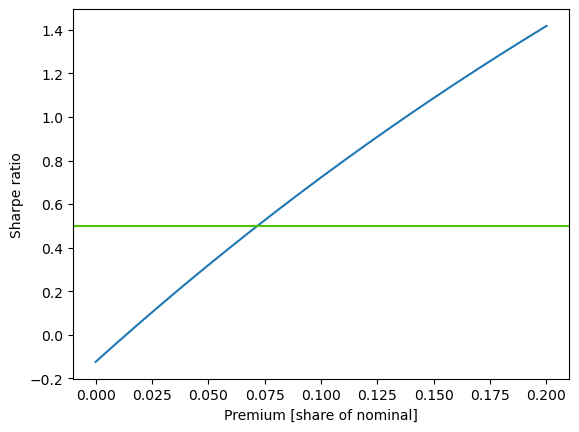

In [184]:
requ_sharpe_ratio = 0.5
requ_premiums = sb.init_requ_premium(requ_sharpe_ratio, premium_simulation, rf_rates) #calculate required premium to match minimum sharpe ratio
sb.display_premiums([requ_premiums], [requ_sharpe_ratio], rf_rates, premium_simulation, exp_loss_ann)   #plot premium versus sharpe ratio

In [17]:
high_yield_bond = pd.read_excel('C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/3_m_treasury.xlsx')
mean_hy = high_yield_bond['Return'].mean()
risk_free_hy = high_yield_bond['Risk free'].mean()
std_hy = high_yield_bond['Return'].std()
VaR_01_hy = high_yield_bond['Return'].quantile(0.01)
VaR_05_hy = high_yield_bond['Return'].quantile(0.05)
ES_01_hy = high_yield_bond['Return'][high_yield_bond['Return'] < VaR_01_hy].mean() *-1
ES_05_hy = high_yield_bond['Return'][high_yield_bond['Return'] < VaR_05_hy].mean() *-1
sharpe_hy = (mean_hy - risk_free_hy) / std_hy
cond_sharpe_hy_01 = (mean_hy - risk_free_hy) / ES_01_hy
cond_sharpe_hy_05 = (mean_hy - risk_free_hy) / ES_05_hy

print('High yield bond sharpe ratio: ', sharpe_hy)
print('High yield bond conditional sharpe ratio (0.01): ', cond_sharpe_hy_01)
print('High yield bond conditional sharpe ratio (0.05): ', cond_sharpe_hy_05)

#p = requ_premiums
#premium_simulation_p, returns_p = sb.init_bond_simulation(pay_dam_df, p, rf_rates, nominal) #simulate cat bond using a Monte Carlo simulation
#print('Nat cat bond sharpe ratio: ', premium_simulation_p['Sharpe_ratio_ann'][0])
#print('Nat cat bond conditional sharpe ratio (0.01): ', premium_simulation_p['Cond_sharpe_ratio_01'][0])
#print('Nat cat bond conditional sharpe ratio (0.05): ', premium_simulation_p['Cond_sharpe_ratio_05'][0])

High yield bond sharpe ratio:  0.4230329028471114
High yield bond conditional sharpe ratio (0.01):  0.22385925404644622
High yield bond conditional sharpe ratio (0.05):  0.3749695788185157
Nat cat bond sharpe ratio:  1.0002232248136864


KeyError: 'Cond_sharpe_ratio_01'

In [19]:
#num_simulations = 20000
#
#requ_premium_sim, requ_premium_annual_returns, requ_premium_tot_returns = sb.init_bond_simulation(requ_premium)
#
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
#
#ax1.hist(requ_premium_annual_returns)
#ax1.text(-0.35, num_simulations-1000, f'Std: {round(np.std(requ_premium_annual_returns)*100,2)}%', fontsize = 8)
#ax1.text(-0.35, num_simulations-2000, f'VaR_1%: {round(requ_premium_sim["VaR_01_ann"][0]*100,2)}%', fontsize = 8)
#ax1.text(-0.35, num_simulations-3000, f'ES_1%: {round(requ_premium_sim["ES_01_ann"][0]*100,2)}%', fontsize = 8)
#ax1.text(-0.35, num_simulations-4000, f'Risk margin: {round(requ_premium_sim["Premium"][0]*100,2)}%', fontsize = 8)
#ax1.text(-0.35, num_simulations-5000, f'Sharpe ratio: {round(requ_premium_sim["Sharpe_ratio_ann"][0],2)}', fontsize = 8)
#ax1.text(-0.35, num_simulations-6000, f'Exp return: {round(np.mean(requ_premium_annual_returns)*100,2)}%', fontsize = 8)
#ax1.set_xlabel('Relative Returns')
#ax1.set_ylabel('Frequency')
#ax1.set_title('Histogram of annual returns for a 3-year cat bond')
#
#ax2.hist(requ_premium_tot_returns)
#ax2.text(-1.0, num_simulations-1000, f'Std: {round(np.std(requ_premium_tot_returns)*100,2)}%', fontsize = 8)
#ax2.text(-1.0, num_simulations-2000, f'VaR_1%: {round(requ_premium_sim["VaR_01_tot"][0]*100,2)}%', fontsize = 8)
#ax2.text(-1.0, num_simulations-3000, f'ES_1%: {round(requ_premium_sim["ES_01_tot"][0]*100,2)}%', fontsize = 8)
#ax2.text(-1.0, num_simulations-4000, f'Risk margin: {round(requ_premium_sim["Premium"][0]*100,2)}%', fontsize = 8)
#ax2.text(-1.0, num_simulations-5000, f'Sharpe ratio: {round(requ_premium_sim["Sharpe_ratio_tot"][0],2)}', fontsize = 8)
#ax2.text(-1.0, num_simulations-6000, f'Exp return: {round(np.mean(requ_premium_tot_returns)*100,2)}%', fontsize = 8)
#ax2.set_xlabel('Relative Returns')
##ax2.set_ylabel('Frequency')
#ax2.set_title('Histogram of total returns for a 3-year cat bond')
#
#plt.show()
#

## Perform cat bond simulation using different nominals

In [18]:
#define nominals
prot_share_arr = np.arange(0.01, 0.21, 0.01) #protected share of total exposure
arr_nominal = []

for prot_share in prot_share_arr:
    nominal, tot_exp, nom_rel_exp = snom.init_nominal(impact=None, exposure=exp, prot_share=prot_share, print_nom=False)
    arr_nominal.append(nominal)

print('Nominals calculated')

#optimize payout per grid for each nominal
optimized_xs_nom = {}
optimized_ys_nom = {}
result_nom = {}
pay_dam_df_nom = {}
exp_loss_ann_nom = {}
att_prob_nom = {}
premium_ibrd = {}
premium_artemis = {}
premium_regression = {}
premium_simulation = {}
returns = {}
premium_simulation_ibrd = {}
returns_ibrd = {}
premium_simulation_artemis = {}
returns_artemis = {}
premium_simulation_regression = {}
returns_regression = {}
requ_premiums_mod = {}
requ_premiums_high = {}
premiums = np.arange(0.00, 0.28, 0.01) #set range of premiums, to calculate required premium to beat sharpe ratio

for nom in arr_nominal:
    nom_str = str(nom)
    result_nom[nom_str], optimized_xs_nom[nom_str], optimized_ys_nom[nom_str] = apo.init_alt_optimization(ws_grid, imp_grid_evt_flt, nom, print_params=False)

    pay_dam_df_nom[nom_str] = apo.alt_pay_vs_damage(imp_grid_evt_flt, optimized_xs_nom[nom_str], optimized_ys_nom[nom_str], ws_grid, nom, include_plot=False)
    
    exp_loss_ann_nom[nom_str], att_prob_nom[nom_str], es_metrics[nom_str] = sb.init_exp_loss_att_prob_simulation(pay_dam_df_nom[nom_str], nom, print_prob=False)

    premium_ibrd[nom_str] = prib.monoExp(exp_loss_ann_nom[nom_str] * 100, a, k, b) * exp_loss_ann_nom[nom_str]
    premium_artemis[nom_str] = exp_loss_ann_nom[nom_str] * artemis_multiplier
    premium_regression[nom_str] = cp.calc_premium_regression(exp_loss_ann_nom[nom_str] * 100) / 100
    
    premium_simulation_ibrd[nom_str], returns_ibrd[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_ibrd[nom_str], rf_rates, nom) 
    premium_simulation_artemis[nom_str], returns_artemis[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_artemis[nom_str], rf_rates, nom) 
    premium_simulation_regression[nom_str], returns_regression[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_regression[nom_str], rf_rates, nom) 
    premium_simulation[nom_str], returns[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premiums, rf_rates, nom) 
    
    requ_premiums_mod[nom_str] = sb.init_requ_premium(0.5, premium_simulation[nom_str], rf_rates, print_prem=False)
    requ_premiums_high[nom_str] = sb.init_requ_premium(1.0, premium_simulation[nom_str], rf_rates, print_prem=False) 
    #sb.display_premiums([requ_premiums_mod[nom_str], requ_premiums_high[nom_str]], [1.0, 2.0], rf_rates, premium_simulation[nom_str], exp_loss_ann_nom[nom_str])   

Nominals calculated


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_bond.py:206: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x_intersection = fsolve(intersection_func, x_guess)[0]


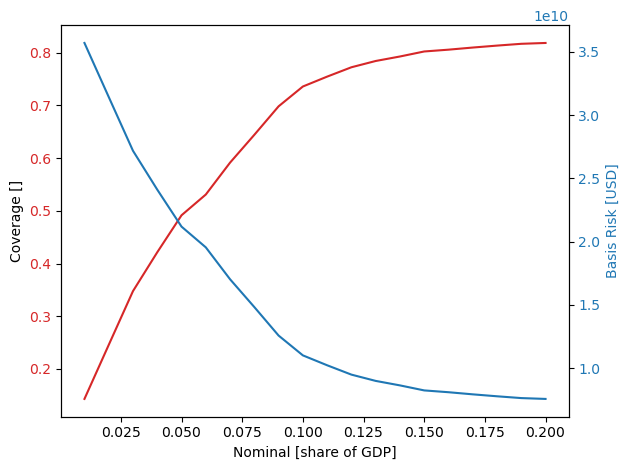

In [24]:
coverage_nom = []
basis_risk_nom = []
tot_pay_nom = []

for nom_it in arr_nominal:
    nom_str = str(nom_it)
    coverage_nom.append(premium_simulation[nom_str]['Coverage'].mean())
    basis_risk_nom.append((premium_simulation[nom_str]['Basis_risk'].mean())*-1)
    tot_pay_nom.append((premium_simulation[nom_str]['Average Payments'].mean())/tot_exp )

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(prot_share_arr, coverage_nom, color=color)
ax1.set_xlabel('Nominal [share of GDP]')
ax1.set_ylabel('Coverage []')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Basis Risk [USD]', color=color)  # we already handled the x-label with ax1
ax2.plot(prot_share_arr, basis_risk_nom, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



plot premium vs coverage. How much do I need to pay for a certain coverage. Also include what a certain coverage would mean money wise for the country -> how much is paid relative to gdp

Think about other coverage metrics -> compare them.

What is good benchmark metric?

Cost-benefit with premium plot.

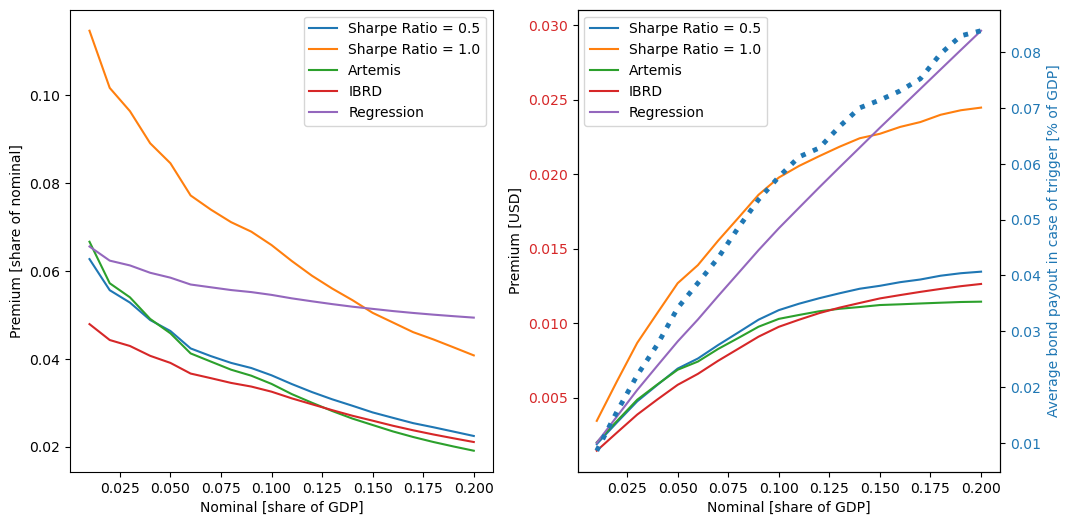

In [25]:

requ_premiums_mod_arr = np.array(fct.get_all_values(requ_premiums_mod))
requ_premiums_high_arr = np.array(fct.get_all_values(requ_premiums_high))
premium_artemis_arr = np.array(fct.get_all_values(premium_artemis))
premium_ibrd_arr = np.array(fct.get_all_values(premium_ibrd))
premium_regression_arr = np.array(fct.get_all_values(premium_regression))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(prot_share_arr, requ_premiums_mod_arr, label='Sharpe Ratio = 0.5')
ax1.plot(prot_share_arr, requ_premiums_high_arr, label='Sharpe Ratio = 1.0')
ax1.plot(prot_share_arr, premium_artemis.values(), label='Artemis')
ax1.plot(prot_share_arr, premium_ibrd.values(), label='IBRD')
ax1.plot(prot_share_arr, premium_regression.values(), label='Regression')
ax1.set_xlabel('Nominal [share of GDP]')
ax1.set_ylabel('Premium [share of nominal]')
ax1.legend()

color = 'tab:red'
ax2.plot(prot_share_arr, (requ_premiums_mod_arr * arr_nominal)*3 / tot_exp, label='Sharpe Ratio = 0.5')
ax2.plot(prot_share_arr, (requ_premiums_high_arr * arr_nominal)*3 / tot_exp, label='Sharpe Ratio = 1.0')
ax2.plot(prot_share_arr, (premium_artemis_arr * arr_nominal)*3 / tot_exp, label='Artemis')
ax2.plot(prot_share_arr, (premium_ibrd_arr * arr_nominal)*3 / tot_exp, label='IBRD')
ax2.plot(prot_share_arr, (premium_regression_arr * arr_nominal)*3 / tot_exp, label='Regression')
ax2.set_xlabel('Nominal [share of GDP]')
ax2.set_ylabel('Premium [USD]')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax2.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:blue'
ax3.set_ylabel('Average bond payout in case of trigger [% of GDP]', color=color)  # we already handled the x-label with ax1
ax3.plot(prot_share_arr, tot_pay_nom, color=color, linewidth=3.5, linestyle='dotted', label='Avg. Payout')
ax3.tick_params(axis='y', labelcolor=color)

ax2.legend()

plt.show()

What sharpe ratio do the calculated premiums imply.

Why do the curves behave like they do? -> make comments

Check on stop payment if payout happpens.

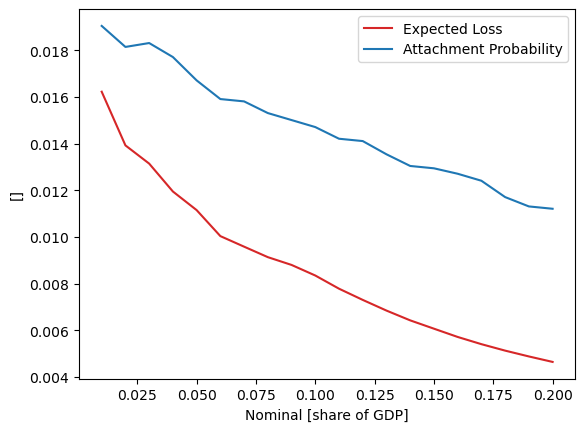

In [26]:
exp_loss_arr = np.array(fct.get_all_values(exp_loss_ann_nom))
att_prob_arr = np.array(fct.get_all_values(att_prob_nom))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(prot_share_arr, exp_loss_arr, color=color, label='Expected Loss')
ax1.set_xlabel('Nominal [share of GDP]')
ax1.set_ylabel('[]')

color = 'tab:blue'
ax1.plot(prot_share_arr, att_prob_arr, color=color, label='Attachment Probability')

plt.legend()
plt.show()

In [22]:
premium_simulation_cond = {}
returns_cond = {}
for nom in arr_nominal:
    nom_str = str(nom)
    premium_simulation_cond[nom_str], returns_cond[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], requ_premiums_mod[nom_str], rf_rates, nom) #simulate cat bond using a Monte Carlo simulation

cond_shp_rat_01 = []
cond_shp_rat_05 = []
for nom in arr_nominal:
    nom_str = str(nom)
    cond_shp_rat_01.append(premium_simulation_cond[nom_str]['Cond_sharpe_ratio_01'][0])
    cond_shp_rat_05.append(premium_simulation_cond[nom_str]['Cond_sharpe_ratio_05'][0])

KeyError: 'Cond_sharpe_ratio_01'

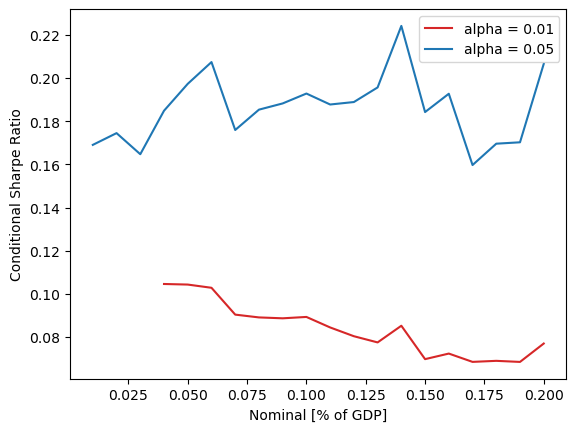

In [41]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(prot_share_arr, cond_shp_rat_01, color=color, label='alpha = 0.01')
ax1.set_xlabel('Nominal [% of GDP]')
ax1.set_ylabel('Conditional Sharpe Ratio')

color = 'tab:blue'
ax1.plot(prot_share_arr, cond_shp_rat_05, color=color, label='alpha = 0.05')

plt.legend()
plt.show()

splitting premiums according to share of single country regarding total of expected shortfall (if this is the driver of pricing)

For a given nominal what premium do I have to pay?

For a given premium how much can I increase the coverage?

Look at cost benefits

In [28]:
import dill
dill.dump_session('C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/sessions/sng_bond.db')